In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=50 # Number of kernels in convolutional network
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
val_rate=0.2
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
# Reshape the coordinates, in order to apply convolutional operation
x = total_coords.reshape((16*9, 2, 55, 1))

In [22]:
# Input of parameters
# These variables are put into the network after convolution and flattening
x_para = np.hstack((aa, hh, bb))

In [23]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [24]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [25]:
cl_orig = target_df.iloc[:,4].values # Cd values
#target_c4 = target_df.iloc[:,4].values# Cl values

In [26]:
cl = (cl_orig-np.min(cl_orig))/(np.max(cl_orig)-np.min(cl_orig))

In [27]:
y = cl.reshape((-1,1))

In [28]:
y.shape

(144, 1)

In [29]:
x_para_all, x_para_test, x_all, x_test, y_all, y_test = train_test_split(x_para, x, y, test_size=test_rate, random_state=1)

In [30]:
x_para_train, x_para_val, x_train, x_val, y_train, y_val = train_test_split(x_para_all, x_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [31]:
tf.keras.backend.set_image_data_format('channels_last')

In [32]:
input_1 = tf.keras.Input(shape=(2,55,1))
input_2 = tf.keras.Input(shape=(3))

x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1, padding='same',
                                 activation='relu', name='convLayer')(input_1)
x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)

x_flat = tf.keras.layers.Flatten()(x_pool)
x_concat = tf.keras.layers.Concatenate()([x_flat, input_2])

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_concat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc5)
# AeroCNN-I
model = tf.keras.Model([input_1, input_2], output_data)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 50)    250         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 50)    0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 1350)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [35]:
model_directory = "D:\\TrainedModels\\20221205"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [36]:
ckpt_name = model_directory + "20221205steadyValidation_AeroCNN1_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" + str(n_units) +"units_OptimalSettingsCl_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-09, min_lr=1e-06, verbose=1)

In [37]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [38]:
start = datetime.datetime.now()
history = model.fit([x_train, x_para_train], y_train, batch_size=batch_size,
                    validation_data=([x_val, x_para_val], y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/5 [=====>........................] - ETA: 20s - loss: 0.5077 - rmse: 0.7125
Epoch 1: val_loss improved from inf to 0.43775, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 6s 81ms/step - loss: 0.4299 - rmse: 0.6557 - val_loss: 0.4377 - val_rmse: 0.6616 - lr: 1.0000e-04
Epoch 2/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.4750 - rmse: 0.6892
Epoch 2: val_loss improved from 0.43775 to 0.41582, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 31ms/step - loss: 0.4076 - rmse: 0.6384 - val_loss: 0.4158 - val_rmse: 0.6448 - lr: 1.0000e-04
Epoch 3/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.3861 - rmse: 0.6214
Epoch 3: val_loss improved from 0.41582 to 0.39180, saving model to D:\TrainedModels\202

Epoch 22/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0364 - rmse: 0.1909
Epoch 22: val_loss improved from 0.03495 to 0.03334, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 31ms/step - loss: 0.0371 - rmse: 0.1927 - val_loss: 0.0333 - val_rmse: 0.1826 - lr: 1.0000e-04
Epoch 23/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0436 - rmse: 0.2087
Epoch 23: val_loss improved from 0.03334 to 0.03153, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 34ms/step - loss: 0.0348 - rmse: 0.1865 - val_loss: 0.0315 - val_rmse: 0.1776 - lr: 1.0000e-04
Epoch 24/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0380 - rmse: 0.1950
Epoch 24: val_loss improved from 0.03153 to 0.02815, saving model to D:\TrainedM

5/5 [==============================] - 0s 36ms/step - loss: 0.0090 - rmse: 0.0947 - val_loss: 0.0091 - val_rmse: 0.0952 - lr: 1.0000e-04
Epoch 43/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0063 - rmse: 0.0796
Epoch 43: val_loss improved from 0.00906 to 0.00859, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 31ms/step - loss: 0.0093 - rmse: 0.0966 - val_loss: 0.0086 - val_rmse: 0.0927 - lr: 1.0000e-04
Epoch 44/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0025 - rmse: 0.0501
Epoch 44: val_loss did not improve from 0.00859
5/5 [==============================] - 0s 13ms/step - loss: 0.0087 - rmse: 0.0935 - val_loss: 0.0086 - val_rmse: 0.0928 - lr: 1.0000e-04
Epoch 45/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0028 - rmse: 0.0532
Epoch 45: val_loss improved from 0.00859 to 0.00848, saving model to D:\TrainedM

1/5 [=====>........................] - ETA: 0s - loss: 0.0017 - rmse: 0.0415
Epoch 91: val_loss improved from 0.00698 to 0.00690, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 32ms/step - loss: 0.0075 - rmse: 0.0868 - val_loss: 0.0069 - val_rmse: 0.0831 - lr: 1.0000e-04
Epoch 92/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0077 - rmse: 0.0878
Epoch 92: val_loss did not improve from 0.00690
5/5 [==============================] - 0s 13ms/step - loss: 0.0074 - rmse: 0.0862 - val_loss: 0.0071 - val_rmse: 0.0843 - lr: 1.0000e-04
Epoch 93/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0071 - rmse: 0.0840
Epoch 93: val_loss improved from 0.00690 to 0.00680, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 35ms/

Epoch 116/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0164 - rmse: 0.1282
Epoch 116: val_loss did not improve from 0.00637
5/5 [==============================] - 0s 12ms/step - loss: 0.0073 - rmse: 0.0856 - val_loss: 0.0067 - val_rmse: 0.0818 - lr: 1.0000e-04
Epoch 117/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 117: val_loss improved from 0.00637 to 0.00637, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 31ms/step - loss: 0.0074 - rmse: 0.0860 - val_loss: 0.0064 - val_rmse: 0.0798 - lr: 1.0000e-04
Epoch 118/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0045 - rmse: 0.0674
Epoch 118: val_loss did not improve from 0.00637
5/5 [==============================] - 0s 13ms/step - loss: 0.0070 - rmse: 0.0835 - val_loss: 0.0068 - val_rmse: 0.0827 - lr: 1.0000e-04
Epoch 119/10000
1/5 [=====

5/5 [==============================] - 0s 29ms/step - loss: 0.0072 - rmse: 0.0846 - val_loss: 0.0060 - val_rmse: 0.0777 - lr: 1.0000e-04
Epoch 142/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0147 - rmse: 0.1213
Epoch 142: val_loss did not improve from 0.00604
5/5 [==============================] - 0s 13ms/step - loss: 0.0072 - rmse: 0.0851 - val_loss: 0.0064 - val_rmse: 0.0800 - lr: 1.0000e-04
Epoch 143/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0074 - rmse: 0.0860
Epoch 143: val_loss improved from 0.00604 to 0.00594, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 33ms/step - loss: 0.0065 - rmse: 0.0806 - val_loss: 0.0059 - val_rmse: 0.0771 - lr: 1.0000e-04
Epoch 144/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0061 - rmse: 0.0780
Epoch 144: val_loss did not improve from 0.00594
5/5 [=====================

Epoch 168/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0061 - rmse: 0.0779
Epoch 168: val_loss improved from 0.00565 to 0.00562, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 31ms/step - loss: 0.0061 - rmse: 0.0781 - val_loss: 0.0056 - val_rmse: 0.0750 - lr: 1.0000e-04
Epoch 169/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0068 - rmse: 0.0824
Epoch 169: val_loss did not improve from 0.00562
5/5 [==============================] - 0s 12ms/step - loss: 0.0061 - rmse: 0.0782 - val_loss: 0.0058 - val_rmse: 0.0758 - lr: 1.0000e-04
Epoch 170/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0141 - rmse: 0.1187
Epoch 170: val_loss did not improve from 0.00562
5/5 [==============================] - 0s 13ms/step - loss: 0.0062 - rmse: 0.0789 - val_loss: 0.0056 - val_rmse: 0.0751 - lr: 1.0000e-04
Epoch 171/10000
1/5 [=====

5/5 [==============================] - 0s 32ms/step - loss: 0.0059 - rmse: 0.0765 - val_loss: 0.0053 - val_rmse: 0.0726 - lr: 1.0000e-04
Epoch 194/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0091 - rmse: 0.0957
Epoch 194: val_loss did not improve from 0.00527
5/5 [==============================] - 0s 13ms/step - loss: 0.0058 - rmse: 0.0763 - val_loss: 0.0055 - val_rmse: 0.0740 - lr: 1.0000e-04
Epoch 195/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0047 - rmse: 0.0688
Epoch 195: val_loss improved from 0.00527 to 0.00520, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 29ms/step - loss: 0.0059 - rmse: 0.0769 - val_loss: 0.0052 - val_rmse: 0.0721 - lr: 1.0000e-04
Epoch 196/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0043 - rmse: 0.0656
Epoch 196: val_loss did not improve from 0.00520
5/5 [=====================

Epoch 220/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0481
Epoch 220: val_loss did not improve from 0.00485
5/5 [==============================] - 0s 12ms/step - loss: 0.0054 - rmse: 0.0732 - val_loss: 0.0053 - val_rmse: 0.0726 - lr: 1.0000e-04
Epoch 221/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0511
Epoch 221: val_loss did not improve from 0.00485
5/5 [==============================] - 0s 13ms/step - loss: 0.0053 - rmse: 0.0730 - val_loss: 0.0049 - val_rmse: 0.0697 - lr: 1.0000e-04
Epoch 222/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0035 - rmse: 0.0595
Epoch 222: val_loss did not improve from 0.00485
5/5 [==============================] - 0s 12ms/step - loss: 0.0053 - rmse: 0.0730 - val_loss: 0.0051 - val_rmse: 0.0711 - lr: 1.0000e-04
Epoch 223/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0025 - rmse: 0.0503
Epoch 223: val_loss did not improve from 0.00485
5/5 [================

Epoch 247/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0053 - rmse: 0.0730
Epoch 247: val_loss improved from 0.00449 to 0.00448, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 40ms/step - loss: 0.0050 - rmse: 0.0705 - val_loss: 0.0045 - val_rmse: 0.0669 - lr: 1.0000e-04
Epoch 248/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0113 - rmse: 0.1061
Epoch 248: val_loss did not improve from 0.00448
5/5 [==============================] - 0s 13ms/step - loss: 0.0049 - rmse: 0.0702 - val_loss: 0.0047 - val_rmse: 0.0685 - lr: 1.0000e-04
Epoch 249/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 249: val_loss did not improve from 0.00448
5/5 [==============================] - 0s 13ms/step - loss: 0.0050 - rmse: 0.0704 - val_loss: 0.0047 - val_rmse: 0.0684 - lr: 1.0000e-04
Epoch 250/10000
1/5 [=====

5/5 [==============================] - 0s 13ms/step - loss: 0.0046 - rmse: 0.0677 - val_loss: 0.0045 - val_rmse: 0.0667 - lr: 1.0000e-04
Epoch 273/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0034 - rmse: 0.0583
Epoch 273: val_loss improved from 0.00410 to 0.00405, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 36ms/step - loss: 0.0046 - rmse: 0.0675 - val_loss: 0.0041 - val_rmse: 0.0637 - lr: 1.0000e-04
Epoch 274/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0053 - rmse: 0.0725
Epoch 274: val_loss did not improve from 0.00405
5/5 [==============================] - 0s 13ms/step - loss: 0.0044 - rmse: 0.0664 - val_loss: 0.0042 - val_rmse: 0.0650 - lr: 1.0000e-04
Epoch 275/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7553e-04 - rmse: 0.0218
Epoch 275: val_loss did not improve from 0.00405
5/5 [=================

5/5 [==============================] - 0s 13ms/step - loss: 0.0043 - rmse: 0.0658 - val_loss: 0.0038 - val_rmse: 0.0615 - lr: 1.0000e-04
Epoch 299/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0064 - rmse: 0.0801
Epoch 299: val_loss did not improve from 0.00352
5/5 [==============================] - 0s 13ms/step - loss: 0.0042 - rmse: 0.0649 - val_loss: 0.0038 - val_rmse: 0.0617 - lr: 1.0000e-04
Epoch 300/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.5843e-04 - rmse: 0.0275
Epoch 300: val_loss did not improve from 0.00352
5/5 [==============================] - 0s 12ms/step - loss: 0.0044 - rmse: 0.0663 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 1.0000e-04
Epoch 301/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0323
Epoch 301: val_loss did not improve from 0.00352
5/5 [==============================] - 0s 13ms/step - loss: 0.0041 - rmse: 0.0643 - val_loss: 0.0046 - val_rmse: 0.0680 - lr: 1.0000e-04
Epoch 302/10000
1/5 [=

5/5 [==============================] - 0s 13ms/step - loss: 0.0035 - rmse: 0.0590 - val_loss: 0.0031 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 324/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0365
Epoch 324: val_loss improved from 0.00310 to 0.00310, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 36ms/step - loss: 0.0035 - rmse: 0.0588 - val_loss: 0.0031 - val_rmse: 0.0557 - lr: 1.0000e-04
Epoch 325/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0457
Epoch 325: val_loss improved from 0.00310 to 0.00306, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 42ms/step - loss: 0.0035 - rmse: 0.0591 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 326/10000
1/5 [=====>....

5/5 [==============================] - 0s 35ms/step - loss: 0.0031 - rmse: 0.0556 - val_loss: 0.0027 - val_rmse: 0.0523 - lr: 1.0000e-04
Epoch 350/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4138e-04 - rmse: 0.0290
Epoch 350: val_loss did not improve from 0.00274
5/5 [==============================] - 0s 12ms/step - loss: 0.0030 - rmse: 0.0547 - val_loss: 0.0028 - val_rmse: 0.0527 - lr: 1.0000e-04
Epoch 351/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0341
Epoch 351: val_loss improved from 0.00274 to 0.00273, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 32ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0027 - val_rmse: 0.0523 - lr: 1.0000e-04
Epoch 352/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0470
Epoch 352: val_loss did not improve from 0.00273
5/5 [=================

Epoch 376/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0051 - rmse: 0.0712
Epoch 376: val_loss improved from 0.00225 to 0.00221, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 38ms/step - loss: 0.0025 - rmse: 0.0503 - val_loss: 0.0022 - val_rmse: 0.0470 - lr: 1.0000e-04
Epoch 377/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7502e-04 - rmse: 0.0218
Epoch 377: val_loss did not improve from 0.00221
5/5 [==============================] - 0s 13ms/step - loss: 0.0025 - rmse: 0.0504 - val_loss: 0.0026 - val_rmse: 0.0511 - lr: 1.0000e-04
Epoch 378/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0363
Epoch 378: val_loss improved from 0.00221 to 0.00218, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [=================

5/5 [==============================] - 0s 13ms/step - loss: 0.0020 - rmse: 0.0452 - val_loss: 0.0017 - val_rmse: 0.0417 - lr: 1.0000e-04
Epoch 401/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0038 - rmse: 0.0616
Epoch 401: val_loss improved from 0.00171 to 0.00169, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 29ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0017 - val_rmse: 0.0411 - lr: 1.0000e-04
Epoch 402/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0404
Epoch 402: val_loss did not improve from 0.00169
5/5 [==============================] - 0s 13ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0019 - val_rmse: 0.0435 - lr: 1.0000e-04
Epoch 403/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0050 - rmse: 0.0705
Epoch 403: val_loss did not improve from 0.00169
5/5 [=====================

Epoch 427/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0421
Epoch 427: val_loss did not improve from 0.00139
5/5 [==============================] - 0s 13ms/step - loss: 0.0022 - rmse: 0.0469 - val_loss: 0.0014 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 428/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0346
Epoch 428: val_loss improved from 0.00139 to 0.00128, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 28ms/step - loss: 0.0022 - rmse: 0.0468 - val_loss: 0.0013 - val_rmse: 0.0357 - lr: 1.0000e-04
Epoch 429/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0041 - rmse: 0.0642
Epoch 429: val_loss did not improve from 0.00128
5/5 [==============================] - 0s 13ms/step - loss: 0.0028 - rmse: 0.0525 - val_loss: 0.0029 - val_rmse: 0.0542 - lr: 1.0000e-04
Epoch 430/10000
1/5 [=====

Epoch 453/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6158e-04 - rmse: 0.0237
Epoch 453: val_loss did not improve from 0.00102
5/5 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0366 - val_loss: 0.0011 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 454/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4794e-04 - rmse: 0.0291
Epoch 454: val_loss did not improve from 0.00102
5/5 [==============================] - 0s 12ms/step - loss: 0.0013 - rmse: 0.0363 - val_loss: 0.0011 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 455/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0468
Epoch 455: val_loss did not improve from 0.00102
5/5 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0367 - val_loss: 0.0011 - val_rmse: 0.0328 - lr: 1.0000e-04
Epoch 456/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0389
Epoch 456: val_loss did not improve from 0.00102
5/5 [========

5/5 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0333 - val_loss: 7.4219e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 480/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6159e-04 - rmse: 0.0294
Epoch 480: val_loss did not improve from 0.00065
5/5 [==============================] - 0s 12ms/step - loss: 0.0010 - rmse: 0.0317 - val_loss: 7.3814e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 481/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0324
Epoch 481: val_loss did not improve from 0.00065
5/5 [==============================] - 0s 13ms/step - loss: 9.8312e-04 - rmse: 0.0314 - val_loss: 7.4348e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 482/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0422
Epoch 482: val_loss improved from 0.00065 to 0.00064, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [=

Epoch 506/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7895e-04 - rmse: 0.0167
Epoch 506: val_loss did not improve from 0.00049
5/5 [==============================] - 0s 13ms/step - loss: 7.7370e-04 - rmse: 0.0278 - val_loss: 6.0483e-04 - val_rmse: 0.0246 - lr: 1.0000e-04
Epoch 507/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0377
Epoch 507: val_loss did not improve from 0.00049
5/5 [==============================] - 0s 12ms/step - loss: 7.9967e-04 - rmse: 0.0283 - val_loss: 5.2733e-04 - val_rmse: 0.0230 - lr: 1.0000e-04
Epoch 508/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 508: val_loss did not improve from 0.00049
5/5 [==============================] - 0s 13ms/step - loss: 9.8598e-04 - rmse: 0.0314 - val_loss: 0.0012 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 509/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0448
Epoch 509: val_loss did not improve from 0.000

Epoch 532/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4054e-04 - rmse: 0.0253
Epoch 532: val_loss did not improve from 0.00040
5/5 [==============================] - 0s 13ms/step - loss: 6.7611e-04 - rmse: 0.0260 - val_loss: 6.0704e-04 - val_rmse: 0.0246 - lr: 1.0000e-04
Epoch 533/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6039e-04 - rmse: 0.0215
Epoch 533: val_loss did not improve from 0.00040
5/5 [==============================] - 0s 13ms/step - loss: 5.9692e-04 - rmse: 0.0244 - val_loss: 4.0317e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 534/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7811e-04 - rmse: 0.0167
Epoch 534: val_loss did not improve from 0.00040
5/5 [==============================] - 0s 13ms/step - loss: 5.8211e-04 - rmse: 0.0241 - val_loss: 4.3494e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 535/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1173e-04 - rmse: 0.0146
Epoch 535: val_loss did not im

Epoch 585/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6626e-04 - rmse: 0.0191
Epoch 585: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 13ms/step - loss: 4.4052e-04 - rmse: 0.0210 - val_loss: 2.5355e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 586/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9666e-04 - rmse: 0.0140
Epoch 586: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 13ms/step - loss: 4.6449e-04 - rmse: 0.0216 - val_loss: 2.7886e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 587/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1709e-04 - rmse: 0.0108
Epoch 587: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 13ms/step - loss: 3.5777e-04 - rmse: 0.0189 - val_loss: 2.8667e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 588/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.1111e-04 - rmse: 0.0226
Epoch 588: val_loss did not im

5/5 [==============================] - 0s 32ms/step - loss: 3.1312e-04 - rmse: 0.0177 - val_loss: 1.8957e-04 - val_rmse: 0.0138 - lr: 1.0000e-04
Epoch 613/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3058e-05 - rmse: 0.0091
Epoch 613: val_loss did not improve from 0.00019
5/5 [==============================] - 0s 12ms/step - loss: 2.7172e-04 - rmse: 0.0165 - val_loss: 2.5779e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 614/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.3427e-04 - rmse: 0.0231
Epoch 614: val_loss did not improve from 0.00019
5/5 [==============================] - 0s 12ms/step - loss: 3.8411e-04 - rmse: 0.0196 - val_loss: 4.1260e-04 - val_rmse: 0.0203 - lr: 1.0000e-04
Epoch 615/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3772e-04 - rmse: 0.0253
Epoch 615: val_loss did not improve from 0.00019
5/5 [==============================] - 0s 13ms/step - loss: 4.9385e-04 - rmse: 0.0222 - val_loss: 4.7670e-04 - val_rmse: 0.0218

Epoch 668/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4484e-04 - rmse: 0.0120
Epoch 668: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 13ms/step - loss: 1.3091e-04 - rmse: 0.0114 - val_loss: 1.9577e-04 - val_rmse: 0.0140 - lr: 1.0000e-04
Epoch 669/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4317e-04 - rmse: 0.0120
Epoch 669: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 13ms/step - loss: 1.4188e-04 - rmse: 0.0119 - val_loss: 1.7593e-04 - val_rmse: 0.0133 - lr: 1.0000e-04
Epoch 670/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3761e-04 - rmse: 0.0117
Epoch 670: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 13ms/step - loss: 1.3240e-04 - rmse: 0.0115 - val_loss: 1.7783e-04 - val_rmse: 0.0133 - lr: 1.0000e-04
Epoch 671/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5729e-04 - rmse: 0.0125
Epoch 671: val_loss improved f

Epoch 695/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3903e-05 - rmse: 0.0086
Epoch 695: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 13ms/step - loss: 1.0056e-04 - rmse: 0.0100 - val_loss: 2.4406e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 696/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3375e-04 - rmse: 0.0116
Epoch 696: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 13ms/step - loss: 9.4098e-05 - rmse: 0.0097 - val_loss: 1.7726e-04 - val_rmse: 0.0133 - lr: 1.0000e-04
Epoch 697/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5057e-05 - rmse: 0.0081
Epoch 697: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 13ms/step - loss: 8.4198e-05 - rmse: 0.0092 - val_loss: 1.7138e-04 - val_rmse: 0.0131 - lr: 1.0000e-04
Epoch 698/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.7842e-05 - rmse: 0.0082
Epoch 698: val_loss did not im

Epoch 723/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6923e-05 - rmse: 0.0041
Epoch 723: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 13ms/step - loss: 8.7379e-05 - rmse: 0.0093 - val_loss: 1.9487e-04 - val_rmse: 0.0140 - lr: 1.0000e-04
Epoch 724/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6075e-04 - rmse: 0.0127
Epoch 724: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 12ms/step - loss: 9.3191e-05 - rmse: 0.0097 - val_loss: 2.3869e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 725/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8577e-05 - rmse: 0.0070
Epoch 725: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 13ms/step - loss: 8.5148e-05 - rmse: 0.0092 - val_loss: 1.6099e-04 - val_rmse: 0.0127 - lr: 1.0000e-04
Epoch 726/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7249e-05 - rmse: 0.0061
Epoch 726: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 4.5423e-05 - rmse: 0.0067
Epoch 779: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 13ms/step - loss: 6.0684e-05 - rmse: 0.0078 - val_loss: 1.8265e-04 - val_rmse: 0.0135 - lr: 1.0000e-04
Epoch 780/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4751e-05 - rmse: 0.0067
Epoch 780: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 12ms/step - loss: 5.2674e-05 - rmse: 0.0073 - val_loss: 1.6452e-04 - val_rmse: 0.0128 - lr: 1.0000e-04
Epoch 781/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4590e-05 - rmse: 0.0059
Epoch 781: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 13ms/step - loss: 5.6827e-05 - rmse: 0.0075 - val_loss: 1.9699e-04 - val_rmse: 0.0140 - lr: 1.0000e-04
Epoch 782/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5569e-05 - rmse: 0.0081
Epoch 782: val_loss did not improve from 0.000

Epoch 835/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5969e-05 - rmse: 0.0068
Epoch 835: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 13ms/step - loss: 3.7028e-05 - rmse: 0.0061 - val_loss: 1.4805e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 836/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2663e-05 - rmse: 0.0048
Epoch 836: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 13ms/step - loss: 4.2288e-05 - rmse: 0.0065 - val_loss: 1.9344e-04 - val_rmse: 0.0139 - lr: 1.0000e-04
Epoch 837/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.0326e-05 - rmse: 0.0090
Epoch 837: val_loss did not improve from 0.00015
5/5 [==============================] - 0s 13ms/step - loss: 4.5163e-05 - rmse: 0.0067 - val_loss: 1.5322e-04 - val_rmse: 0.0124 - lr: 1.0000e-04
Epoch 838/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0389e-05 - rmse: 0.0071
Epoch 838: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 5.0654e-05 - rmse: 0.0071
Epoch 889: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 6.3177e-05 - rmse: 0.0079 - val_loss: 1.8543e-04 - val_rmse: 0.0136 - lr: 1.0000e-04
Epoch 890/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.4427e-05 - rmse: 0.0086
Epoch 890: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 4.9095e-05 - rmse: 0.0070 - val_loss: 1.4873e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 891/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3422e-05 - rmse: 0.0048
Epoch 891: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 5.1382e-05 - rmse: 0.0072 - val_loss: 1.4194e-04 - val_rmse: 0.0119 - lr: 1.0000e-04
Epoch 892/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8608e-05 - rmse: 0.0053
Epoch 892: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 2.2780e-04 - rmse: 0.0151
Epoch 944: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 1.4217e-04 - rmse: 0.0119 - val_loss: 1.7204e-04 - val_rmse: 0.0131 - lr: 1.0000e-04
Epoch 945/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.1699e-05 - rmse: 0.0090
Epoch 945: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 1.0082e-04 - rmse: 0.0100 - val_loss: 1.9762e-04 - val_rmse: 0.0141 - lr: 1.0000e-04
Epoch 946/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1117e-05 - rmse: 0.0046
Epoch 946: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 1.0871e-04 - rmse: 0.0104 - val_loss: 1.7686e-04 - val_rmse: 0.0133 - lr: 1.0000e-04
Epoch 947/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9403e-04 - rmse: 0.0171
Epoch 947: val_loss did not improve from 0.000

Epoch 972/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.5408e-05 - rmse: 0.0074
Epoch 972: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 3.4963e-05 - rmse: 0.0059 - val_loss: 1.3145e-04 - val_rmse: 0.0115 - lr: 1.0000e-04
Epoch 973/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7629e-05 - rmse: 0.0042
Epoch 973: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 3.1747e-05 - rmse: 0.0056 - val_loss: 1.3059e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 974/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7568e-05 - rmse: 0.0053
Epoch 974: val_loss did not improve from 0.00012
5/5 [==============================] - 0s 13ms/step - loss: 4.1160e-05 - rmse: 0.0064 - val_loss: 1.2476e-04 - val_rmse: 0.0112 - lr: 1.0000e-04
Epoch 975/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7890e-05 - rmse: 0.0042
Epoch 975: val_loss did not im

Epoch 1000/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9506e-05 - rmse: 0.0044
Epoch 1000: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 13ms/step - loss: 7.6623e-05 - rmse: 0.0088 - val_loss: 1.3568e-04 - val_rmse: 0.0116 - lr: 1.0000e-04
Epoch 1001/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5126e-05 - rmse: 0.0039
Epoch 1001: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 13ms/step - loss: 7.3657e-05 - rmse: 0.0086 - val_loss: 1.3929e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1002/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7566e-05 - rmse: 0.0053
Epoch 1002: val_loss did not improve from 0.00011
5/5 [==============================] - 0s 13ms/step - loss: 5.0802e-05 - rmse: 0.0071 - val_loss: 1.5220e-04 - val_rmse: 0.0123 - lr: 1.0000e-04
Epoch 1003/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4339e-05 - rmse: 0.0080
Epoch 1003: val_loss di

Epoch 1027/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4965e-05 - rmse: 0.0059
Epoch 1027: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 14ms/step - loss: 2.5591e-05 - rmse: 0.0051 - val_loss: 1.2187e-04 - val_rmse: 0.0110 - lr: 1.0000e-04
Epoch 1028/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.6055e-06 - rmse: 0.0028
Epoch 1028: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 3.2108e-05 - rmse: 0.0057 - val_loss: 1.1677e-04 - val_rmse: 0.0108 - lr: 1.0000e-04
Epoch 1029/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2383e-05 - rmse: 0.0035
Epoch 1029: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 3.3205e-05 - rmse: 0.0058 - val_loss: 1.8887e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 1030/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1782e-04 - rmse: 0.0109
Epoch 1030: val_loss di

5/5 [==============================] - 0s 27ms/step - loss: 7.0479e-05 - rmse: 0.0084 - val_loss: 1.0013e-04 - val_rmse: 0.0100 - lr: 1.0000e-04
Epoch 1055/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5440e-05 - rmse: 0.0050
Epoch 1055: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 8.1007e-05 - rmse: 0.0090 - val_loss: 2.1881e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 1056/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1283e-04 - rmse: 0.0106
Epoch 1056: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 8.8894e-05 - rmse: 0.0094 - val_loss: 1.9101e-04 - val_rmse: 0.0138 - lr: 1.0000e-04
Epoch 1057/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6120e-04 - rmse: 0.0127
Epoch 1057: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 8.3349e-05 - rmse: 0.0091 - val_loss: 2.5187e-04 - val_rmse: 

5/5 [==============================] - 0s 13ms/step - loss: 2.1949e-05 - rmse: 0.0047 - val_loss: 1.1983e-04 - val_rmse: 0.0109 - lr: 1.0000e-04
Epoch 1083/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4945e-05 - rmse: 0.0039
Epoch 1083: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 3.4744e-05 - rmse: 0.0059 - val_loss: 1.2308e-04 - val_rmse: 0.0111 - lr: 1.0000e-04
Epoch 1084/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6627e-05 - rmse: 0.0041
Epoch 1084: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 3.3331e-05 - rmse: 0.0058 - val_loss: 1.3154e-04 - val_rmse: 0.0115 - lr: 1.0000e-04
Epoch 1085/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9303e-05 - rmse: 0.0044
Epoch 1085: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 2.1522e-05 - rmse: 0.0046 - val_loss: 1.6157e-04 - val_rmse: 

5/5 [==============================] - 0s 13ms/step - loss: 1.4985e-05 - rmse: 0.0039 - val_loss: 1.2002e-04 - val_rmse: 0.0110 - lr: 1.0000e-04
Epoch 1111/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9977e-05 - rmse: 0.0045
Epoch 1111: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 1.9954e-05 - rmse: 0.0045 - val_loss: 1.4664e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1112/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1038e-05 - rmse: 0.0033
Epoch 1112: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 1.9338e-05 - rmse: 0.0044 - val_loss: 1.2221e-04 - val_rmse: 0.0111 - lr: 1.0000e-04
Epoch 1113/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4536e-05 - rmse: 0.0067
Epoch 1113: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 3.3035e-05 - rmse: 0.0057 - val_loss: 1.5263e-04 - val_rmse: 

5/5 [==============================] - 0s 16ms/step - loss: 1.0889e-04 - rmse: 0.0104 - val_loss: 2.5236e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 1139/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1272e-04 - rmse: 0.0106
Epoch 1139: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 15ms/step - loss: 1.2433e-04 - rmse: 0.0112 - val_loss: 1.2122e-04 - val_rmse: 0.0110 - lr: 1.0000e-04
Epoch 1140/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9844e-05 - rmse: 0.0055
Epoch 1140: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 15ms/step - loss: 6.9669e-05 - rmse: 0.0083 - val_loss: 1.8871e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 1141/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8403e-05 - rmse: 0.0053
Epoch 1141: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 15ms/step - loss: 5.1080e-05 - rmse: 0.0071 - val_loss: 1.5026e-04 - val_rmse: 

Epoch 1166/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.3494e-05 - rmse: 0.0073
Epoch 1166: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 14ms/step - loss: 2.3910e-04 - rmse: 0.0155 - val_loss: 2.4220e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 1167/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.1606e-05 - rmse: 0.0085
Epoch 1167: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 1.8354e-04 - rmse: 0.0135 - val_loss: 2.3452e-04 - val_rmse: 0.0153 - lr: 1.0000e-04
Epoch 1168/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.5580e-05 - rmse: 0.0075
Epoch 1168: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 14ms/step - loss: 6.5473e-04 - rmse: 0.0256 - val_loss: 7.9425e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 1169/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.8170e-04 - rmse: 0.0261
Epoch 1169: val_loss di

1/5 [=====>........................] - ETA: 0s - loss: 3.1231e-05 - rmse: 0.0056
Epoch 1194: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 2.8840e-05 - rmse: 0.0054 - val_loss: 1.6237e-04 - val_rmse: 0.0127 - lr: 1.0000e-04
Epoch 1195/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0612e-05 - rmse: 0.0045
Epoch 1195: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 2.4400e-05 - rmse: 0.0049 - val_loss: 1.8328e-04 - val_rmse: 0.0135 - lr: 1.0000e-04
Epoch 1196/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7131e-05 - rmse: 0.0041
Epoch 1196: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 14ms/step - loss: 3.5588e-05 - rmse: 0.0060 - val_loss: 1.4180e-04 - val_rmse: 0.0119 - lr: 1.0000e-04
Epoch 1197/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1499e-05 - rmse: 0.0046
Epoch 1197: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 1.7299e-05 - rmse: 0.0042
Epoch 1222: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 1.5979e-05 - rmse: 0.0040 - val_loss: 2.1220e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 1223/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4398e-05 - rmse: 0.0067
Epoch 1223: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 3.6876e-05 - rmse: 0.0061 - val_loss: 1.2778e-04 - val_rmse: 0.0113 - lr: 1.0000e-04
Epoch 1224/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.7801e-05 - rmse: 0.0088
Epoch 1224: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 4.4481e-05 - rmse: 0.0067 - val_loss: 2.0151e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 1225/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.2962e-05 - rmse: 0.0073
Epoch 1225: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 3.3006e-05 - rmse: 0.0057
Epoch 1250: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 9.0857e-05 - rmse: 0.0095 - val_loss: 1.5807e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 1251/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1116e-05 - rmse: 0.0046
Epoch 1251: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 9.1098e-05 - rmse: 0.0095 - val_loss: 1.3235e-04 - val_rmse: 0.0115 - lr: 1.0000e-04
Epoch 1252/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9840e-05 - rmse: 0.0045
Epoch 1252: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 1.5679e-04 - rmse: 0.0125 - val_loss: 1.7956e-04 - val_rmse: 0.0134 - lr: 1.0000e-04
Epoch 1253/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7933e-05 - rmse: 0.0076
Epoch 1253: val_loss did not improve fro

Epoch 1278/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8059e-04 - rmse: 0.0168
Epoch 1278: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 1.7302e-04 - rmse: 0.0132 - val_loss: 2.5386e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 1279/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1097e-04 - rmse: 0.0105
Epoch 1279: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 1.2291e-04 - rmse: 0.0111 - val_loss: 2.0135e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 1280/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1246e-05 - rmse: 0.0056
Epoch 1280: val_loss did not improve from 0.00010
5/5 [==============================] - 0s 13ms/step - loss: 9.3808e-05 - rmse: 0.0097 - val_loss: 2.8957e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 1281/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1767e-04 - rmse: 0.0108
Epoch 1281: val_loss di

5/5 [==============================] - 0s 41ms/step - loss: 1.2984e-05 - rmse: 0.0036 - val_loss: 9.4403e-05 - val_rmse: 0.0097 - lr: 1.0000e-04
Epoch 1306/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.8207e-06 - rmse: 0.0026
Epoch 1306: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 1.7203e-05 - rmse: 0.0041 - val_loss: 1.3302e-04 - val_rmse: 0.0115 - lr: 1.0000e-04
Epoch 1307/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.2226e-06 - rmse: 0.0025
Epoch 1307: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 1.7265e-05 - rmse: 0.0042 - val_loss: 1.0520e-04 - val_rmse: 0.0103 - lr: 1.0000e-04
Epoch 1308/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1396e-05 - rmse: 0.0034
Epoch 1308: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 1.5937e-05 - rmse: 0.0040 - val_loss: 1.1478e-04 - val_rmse: 

5/5 [==============================] - 0s 13ms/step - loss: 1.7088e-05 - rmse: 0.0041 - val_loss: 1.1376e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 1334/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3627e-05 - rmse: 0.0037
Epoch 1334: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 2.0744e-05 - rmse: 0.0046 - val_loss: 1.5745e-04 - val_rmse: 0.0125 - lr: 1.0000e-04
Epoch 1335/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0742e-05 - rmse: 0.0055
Epoch 1335: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 2.2970e-05 - rmse: 0.0048 - val_loss: 1.6038e-04 - val_rmse: 0.0127 - lr: 1.0000e-04
Epoch 1336/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0163e-04 - rmse: 0.0101
Epoch 1336: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 5.8838e-05 - rmse: 0.0077 - val_loss: 1.5740e-04 - val_rmse: 

Epoch 1361/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.6715e-05 - rmse: 0.0082
Epoch 1361: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 5.4089e-05 - rmse: 0.0074 - val_loss: 9.4365e-05 - val_rmse: 0.0097 - lr: 1.0000e-04
Epoch 1362/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1756e-05 - rmse: 0.0047
Epoch 1362: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 3.2392e-05 - rmse: 0.0057 - val_loss: 2.0732e-04 - val_rmse: 0.0144 - lr: 1.0000e-04
Epoch 1363/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.4121e-05 - rmse: 0.0074
Epoch 1363: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 4.8093e-05 - rmse: 0.0069 - val_loss: 1.8945e-04 - val_rmse: 0.0138 - lr: 1.0000e-04
Epoch 1364/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1980e-04 - rmse: 0.0109
Epoch 1364: val_loss di

5/5 [==============================] - 0s 30ms/step - loss: 2.3609e-05 - rmse: 0.0049 - val_loss: 8.6212e-05 - val_rmse: 0.0093 - lr: 1.0000e-04
Epoch 1389/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2061e-05 - rmse: 0.0057
Epoch 1389: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 3.0175e-05 - rmse: 0.0055 - val_loss: 1.4441e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 1390/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9347e-05 - rmse: 0.0044
Epoch 1390: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 3.3371e-05 - rmse: 0.0058 - val_loss: 1.4110e-04 - val_rmse: 0.0119 - lr: 1.0000e-04
Epoch 1391/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.8777e-05 - rmse: 0.0089
Epoch 1391: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 3.4095e-05 - rmse: 0.0058 - val_loss: 1.4133e-04 - val_rmse: 

5/5 [==============================] - 0s 14ms/step - loss: 2.4059e-05 - rmse: 0.0049 - val_loss: 1.1170e-04 - val_rmse: 0.0106 - lr: 1.0000e-04
Epoch 1417/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9086e-05 - rmse: 0.0054
Epoch 1417: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 2.7931e-05 - rmse: 0.0053 - val_loss: 1.3767e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 1418/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2037e-05 - rmse: 0.0057
Epoch 1418: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 2.2575e-05 - rmse: 0.0048 - val_loss: 1.2073e-04 - val_rmse: 0.0110 - lr: 1.0000e-04
Epoch 1419/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1268e-06 - rmse: 0.0020
Epoch 1419: val_loss did not improve from 0.00009
5/5 [==============================] - 0s 13ms/step - loss: 2.4334e-05 - rmse: 0.0049 - val_loss: 1.2491e-04 - val_rmse: 

Epoch 1444/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3607e-05 - rmse: 0.0049
Epoch 1444: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 6.2381e-05 - rmse: 0.0079 - val_loss: 8.7429e-05 - val_rmse: 0.0094 - lr: 1.0000e-04
Epoch 1445/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5617e-05 - rmse: 0.0051
Epoch 1445: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 4.5001e-05 - rmse: 0.0067 - val_loss: 2.2117e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 1446/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5884e-05 - rmse: 0.0068
Epoch 1446: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 6.4298e-05 - rmse: 0.0080 - val_loss: 1.2553e-04 - val_rmse: 0.0112 - lr: 1.0000e-04
Epoch 1447/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8424e-05 - rmse: 0.0053
Epoch 1447: val_loss di

Epoch 1472/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9932e-06 - rmse: 0.0024
Epoch 1472: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 7.2652e-06 - rmse: 0.0027 - val_loss: 1.0640e-04 - val_rmse: 0.0103 - lr: 1.0000e-04
Epoch 1473/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4968e-05 - rmse: 0.0039
Epoch 1473: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 7.8150e-06 - rmse: 0.0028 - val_loss: 1.2909e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 1474/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.3354e-05 - rmse: 0.0058
Epoch 1474: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 1.5729e-05 - rmse: 0.0040 - val_loss: 1.2478e-04 - val_rmse: 0.0112 - lr: 1.0000e-04
Epoch 1475/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6497e-05 - rmse: 0.0041
Epoch 1475: val_loss di

Epoch 1500/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3830e-04 - rmse: 0.0154
Epoch 1500: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 2.2419e-04 - rmse: 0.0150 - val_loss: 8.8965e-04 - val_rmse: 0.0298 - lr: 1.0000e-04
Epoch 1501/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3272e-04 - rmse: 0.0271
Epoch 1501: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 3.5093e-04 - rmse: 0.0187 - val_loss: 2.1576e-04 - val_rmse: 0.0147 - lr: 1.0000e-04
Epoch 1502/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5314e-04 - rmse: 0.0124
Epoch 1502: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 2.9259e-04 - rmse: 0.0171 - val_loss: 3.9255e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 1503/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0713e-04 - rmse: 0.0202
Epoch 1503: val_loss di

Epoch 1528/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4295e-06 - rmse: 0.0025
Epoch 1528: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 1.0882e-05 - rmse: 0.0033 - val_loss: 9.4166e-05 - val_rmse: 0.0097 - lr: 1.0000e-04
Epoch 1529/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4896e-06 - rmse: 0.0025
Epoch 1529: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 2.4634e-05 - rmse: 0.0050 - val_loss: 2.0925e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 1530/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.9237e-05 - rmse: 0.0094
Epoch 1530: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 1.1983e-04 - rmse: 0.0109 - val_loss: 9.8818e-05 - val_rmse: 0.0099 - lr: 1.0000e-04
Epoch 1531/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6294e-05 - rmse: 0.0060
Epoch 1531: val_loss di

1/5 [=====>........................] - ETA: 0s - loss: 4.2477e-05 - rmse: 0.0065
Epoch 1556: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 33ms/step - loss: 5.1117e-05 - rmse: 0.0071 - val_loss: 7.7641e-05 - val_rmse: 0.0088 - lr: 1.0000e-04
Epoch 1557/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3729e-05 - rmse: 0.0049
Epoch 1557: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 3.2529e-05 - rmse: 0.0057 - val_loss: 1.4067e-04 - val_rmse: 0.0119 - lr: 1.0000e-04
Epoch 1558/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0516e-05 - rmse: 0.0071
Epoch 1558: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 14ms/step - loss: 3.7920e-05 - rmse: 0.0062 - val_loss: 1.1466e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
E

5/5 [==============================] - 0s 31ms/step - loss: 1.5924e-05 - rmse: 0.0040 - val_loss: 7.7493e-05 - val_rmse: 0.0088 - lr: 1.0000e-04
Epoch 1584/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.8598e-06 - rmse: 0.0028
Epoch 1584: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 2.1475e-05 - rmse: 0.0046 - val_loss: 1.5488e-04 - val_rmse: 0.0124 - lr: 1.0000e-04
Epoch 1585/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6708e-05 - rmse: 0.0075
Epoch 1585: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 3.2841e-05 - rmse: 0.0057 - val_loss: 8.9927e-05 - val_rmse: 0.0095 - lr: 1.0000e-04
Epoch 1586/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5963e-05 - rmse: 0.0051
Epoch 1586: val_loss did not improve from 0.00008
5/5 [==============================] - 0s 13ms/step - loss: 2.2301e-05 - rmse: 0.0047 - val_loss: 9.0565e-05 - val_rmse: 

Epoch 1611/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0419e-04 - rmse: 0.0102
Epoch 1611: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 13ms/step - loss: 7.3209e-05 - rmse: 0.0086 - val_loss: 9.2089e-05 - val_rmse: 0.0096 - lr: 1.0000e-04
Epoch 1612/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4780e-05 - rmse: 0.0059
Epoch 1612: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 13ms/step - loss: 6.1604e-05 - rmse: 0.0078 - val_loss: 1.7523e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 1613/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9490e-05 - rmse: 0.0063
Epoch 1613: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 13ms/step - loss: 6.8273e-05 - rmse: 0.0083 - val_loss: 1.8690e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 1614/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4820e-04 - rmse: 0.0187
Epoch 1614: val_loss di

Epoch 1639/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8607e-05 - rmse: 0.0043
Epoch 1639: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 13ms/step - loss: 4.1638e-05 - rmse: 0.0065 - val_loss: 1.0874e-04 - val_rmse: 0.0104 - lr: 1.0000e-04
Epoch 1640/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9486e-05 - rmse: 0.0054
Epoch 1640: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 13ms/step - loss: 8.2086e-05 - rmse: 0.0091 - val_loss: 2.7885e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 1641/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3684e-04 - rmse: 0.0117
Epoch 1641: val_loss did not improve from 0.00007
5/5 [==============================] - 0s 13ms/step - loss: 8.0473e-05 - rmse: 0.0090 - val_loss: 1.6611e-04 - val_rmse: 0.0129 - lr: 1.0000e-04
Epoch 1642/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2217e-04 - rmse: 0.0111
Epoch 1642: val_loss di

1/5 [=====>........................] - ETA: 0s - loss: 7.9436e-06 - rmse: 0.0028
Epoch 1694: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 1.4531e-05 - rmse: 0.0038 - val_loss: 7.6227e-05 - val_rmse: 0.0087 - lr: 1.0000e-04
Epoch 1695/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7023e-05 - rmse: 0.0041
Epoch 1695: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 2.2448e-05 - rmse: 0.0047 - val_loss: 7.9196e-05 - val_rmse: 0.0089 - lr: 1.0000e-04
Epoch 1696/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.2513e-06 - rmse: 0.0027
Epoch 1696: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 3.0422e-05 - rmse: 0.0055 - val_loss: 7.6073e-05 - val_rmse: 0.0087 - lr: 1.0000e-04
Epoch 1697/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0103e-05 - rmse: 0.0032
Epoch 1697: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 8.1007e-06 - rmse: 0.0028
Epoch 1722: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 7.7782e-06 - rmse: 0.0028 - val_loss: 7.6858e-05 - val_rmse: 0.0088 - lr: 1.0000e-04
Epoch 1723/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0554e-05 - rmse: 0.0032
Epoch 1723: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 1.2632e-05 - rmse: 0.0036 - val_loss: 9.6850e-05 - val_rmse: 0.0098 - lr: 1.0000e-04
Epoch 1724/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0442e-05 - rmse: 0.0032
Epoch 1724: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 1.1201e-05 - rmse: 0.0033 - val_loss: 6.8125e-05 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 1725/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7537e-06 - rmse: 0.0024
Epoch 1725: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 5.6806e-06 - rmse: 0.0024
Epoch 1750: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 9.1425e-06 - rmse: 0.0030 - val_loss: 6.4851e-05 - val_rmse: 0.0081 - lr: 1.0000e-04
Epoch 1751/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7533e-05 - rmse: 0.0042
Epoch 1751: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 14ms/step - loss: 7.7335e-06 - rmse: 0.0028 - val_loss: 8.1419e-05 - val_rmse: 0.0090 - lr: 1.0000e-04
Epoch 1752/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.2627e-06 - rmse: 0.0029
Epoch 1752: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 14ms/step - loss: 6.3913e-06 - rmse: 0.0025 - val_loss: 6.3322e-05 - val_rmse: 0.0080 - lr: 1.0000e-04
Epoch 1753/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.9134e-06 - rmse: 0.0026
Epoch 1753: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 5.1556e-06 - rmse: 0.0023
Epoch 1778: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 14ms/step - loss: 4.4986e-06 - rmse: 0.0021 - val_loss: 8.1568e-05 - val_rmse: 0.0090 - lr: 1.0000e-04
Epoch 1779/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.3210e-06 - rmse: 0.0023
Epoch 1779: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 7.2801e-06 - rmse: 0.0027 - val_loss: 8.3929e-05 - val_rmse: 0.0092 - lr: 1.0000e-04
Epoch 1780/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0545e-06 - rmse: 0.0020
Epoch 1780: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 14ms/step - loss: 7.6314e-06 - rmse: 0.0028 - val_loss: 8.3800e-05 - val_rmse: 0.0092 - lr: 1.0000e-04
Epoch 1781/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6142e-06 - rmse: 0.0016
Epoch 1781: val_loss did not improve fro

Epoch 1806/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.5561e-06 - rmse: 0.0019
Epoch 1806: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 14ms/step - loss: 9.1736e-06 - rmse: 0.0030 - val_loss: 6.8010e-05 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 1807/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0812e-05 - rmse: 0.0033
Epoch 1807: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 1.3932e-05 - rmse: 0.0037 - val_loss: 8.9261e-05 - val_rmse: 0.0094 - lr: 1.0000e-04
Epoch 1808/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8633e-05 - rmse: 0.0054
Epoch 1808: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 2.1849e-05 - rmse: 0.0047 - val_loss: 6.9507e-05 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 1809/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5734e-05 - rmse: 0.0040
Epoch 1809: val_loss di

Epoch 1834/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1083e-05 - rmse: 0.0056
Epoch 1834: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 2.6481e-05 - rmse: 0.0051 - val_loss: 7.8215e-05 - val_rmse: 0.0088 - lr: 1.0000e-04
Epoch 1835/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1181e-05 - rmse: 0.0033
Epoch 1835: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 14ms/step - loss: 1.8668e-05 - rmse: 0.0043 - val_loss: 1.3190e-04 - val_rmse: 0.0115 - lr: 1.0000e-04
Epoch 1836/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5069e-05 - rmse: 0.0039
Epoch 1836: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 1.6512e-05 - rmse: 0.0041 - val_loss: 5.5778e-05 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 1837/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7917e-05 - rmse: 0.0053
Epoch 1837: val_loss di

Epoch 1862/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3680e-06 - rmse: 0.0029
Epoch 1862: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 4.6413e-06 - rmse: 0.0022 - val_loss: 7.7420e-05 - val_rmse: 0.0088 - lr: 1.0000e-04
Epoch 1863/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1271e-06 - rmse: 0.0020
Epoch 1863: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 5.0131e-06 - rmse: 0.0022 - val_loss: 7.1747e-05 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 1864/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0480e-05 - rmse: 0.0032
Epoch 1864: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 5.3101e-06 - rmse: 0.0023 - val_loss: 9.6777e-05 - val_rmse: 0.0098 - lr: 1.0000e-04
Epoch 1865/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4715e-06 - rmse: 0.0025
Epoch 1865: val_loss di

Epoch 1890/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4615e-05 - rmse: 0.0038
Epoch 1890: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 1.1757e-05 - rmse: 0.0034 - val_loss: 7.3801e-05 - val_rmse: 0.0086 - lr: 1.0000e-04
Epoch 1891/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.2627e-06 - rmse: 0.0029
Epoch 1891: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 1.5253e-05 - rmse: 0.0039 - val_loss: 1.1504e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 1892/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2535e-05 - rmse: 0.0065
Epoch 1892: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 2.6643e-05 - rmse: 0.0052 - val_loss: 7.1944e-05 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 1893/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9228e-05 - rmse: 0.0044
Epoch 1893: val_loss di

Epoch 1918/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3915e-06 - rmse: 0.0025
Epoch 1918: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 8.0520e-06 - rmse: 0.0028 - val_loss: 8.0642e-05 - val_rmse: 0.0090 - lr: 1.0000e-04
Epoch 1919/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0270e-06 - rmse: 0.0010
Epoch 1919: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 1.0404e-05 - rmse: 0.0032 - val_loss: 4.8972e-05 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 1920/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2110e-05 - rmse: 0.0047
Epoch 1920: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 14ms/step - loss: 2.3576e-05 - rmse: 0.0049 - val_loss: 1.3849e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1921/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7088e-05 - rmse: 0.0041
Epoch 1921: val_loss di

Epoch 1946/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3635e-05 - rmse: 0.0097
Epoch 1946: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 4.7343e-05 - rmse: 0.0069 - val_loss: 2.0390e-04 - val_rmse: 0.0143 - lr: 1.0000e-04
Epoch 1947/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1999e-04 - rmse: 0.0110
Epoch 1947: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 5.3797e-05 - rmse: 0.0073 - val_loss: 1.1476e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 1948/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4153e-05 - rmse: 0.0080
Epoch 1948: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 5.2675e-05 - rmse: 0.0073 - val_loss: 1.9524e-04 - val_rmse: 0.0140 - lr: 1.0000e-04
Epoch 1949/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8654e-05 - rmse: 0.0077
Epoch 1949: val_loss di

Epoch 1974/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.0824e-06 - rmse: 0.0027
Epoch 1974: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 1.2703e-05 - rmse: 0.0036 - val_loss: 8.7434e-05 - val_rmse: 0.0094 - lr: 1.0000e-04
Epoch 1975/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9779e-05 - rmse: 0.0055
Epoch 1975: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 3.5610e-05 - rmse: 0.0060 - val_loss: 8.8484e-05 - val_rmse: 0.0094 - lr: 1.0000e-04
Epoch 1976/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1270e-05 - rmse: 0.0034
Epoch 1976: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 1.6185e-05 - rmse: 0.0040 - val_loss: 5.0482e-05 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 1977/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5971e-05 - rmse: 0.0040
Epoch 1977: val_loss di

Epoch 2002/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2656e-06 - rmse: 0.0011
Epoch 2002: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 2.5865e-06 - rmse: 0.0016 - val_loss: 6.7701e-05 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 2003/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7065e-06 - rmse: 0.0013
Epoch 2003: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 2.2159e-06 - rmse: 0.0015 - val_loss: 6.1878e-05 - val_rmse: 0.0079 - lr: 5.0000e-05
Epoch 2004/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2682e-06 - rmse: 0.0021
Epoch 2004: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 2.8036e-06 - rmse: 0.0017 - val_loss: 6.8391e-05 - val_rmse: 0.0083 - lr: 5.0000e-05
Epoch 2005/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3046e-06 - rmse: 0.0011
Epoch 2005: val_loss di

Epoch 2030/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4892e-06 - rmse: 0.0012
Epoch 2030: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 3.6742e-06 - rmse: 0.0019 - val_loss: 6.4991e-05 - val_rmse: 0.0081 - lr: 5.0000e-05
Epoch 2031/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2614e-06 - rmse: 0.0011
Epoch 2031: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 3.5441e-06 - rmse: 0.0019 - val_loss: 6.6674e-05 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 2032/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3508e-06 - rmse: 0.0012
Epoch 2032: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 2.8062e-06 - rmse: 0.0017 - val_loss: 7.3362e-05 - val_rmse: 0.0086 - lr: 5.0000e-05
Epoch 2033/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9199e-06 - rmse: 0.0020
Epoch 2033: val_loss di

Epoch 2058/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1262e-06 - rmse: 0.0020
Epoch 2058: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 2.6679e-06 - rmse: 0.0016 - val_loss: 6.6227e-05 - val_rmse: 0.0081 - lr: 5.0000e-05
Epoch 2059/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0476e-06 - rmse: 0.0010
Epoch 2059: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 1.9171e-06 - rmse: 0.0014 - val_loss: 6.8604e-05 - val_rmse: 0.0083 - lr: 5.0000e-05
Epoch 2060/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2993e-06 - rmse: 0.0018
Epoch 2060: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 2.0809e-06 - rmse: 0.0014 - val_loss: 7.0897e-05 - val_rmse: 0.0084 - lr: 5.0000e-05
Epoch 2061/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0655e-06 - rmse: 0.0010
Epoch 2061: val_loss di

Epoch 2086/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5856e-06 - rmse: 0.0016
Epoch 2086: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 3.6471e-06 - rmse: 0.0019 - val_loss: 6.3937e-05 - val_rmse: 0.0080 - lr: 5.0000e-05
Epoch 2087/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3998e-06 - rmse: 0.0015
Epoch 2087: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 6.4231e-06 - rmse: 0.0025 - val_loss: 6.5662e-05 - val_rmse: 0.0081 - lr: 5.0000e-05
Epoch 2088/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5767e-06 - rmse: 0.0021
Epoch 2088: val_loss did not improve from 0.00005
5/5 [==============================] - 0s 13ms/step - loss: 7.3764e-06 - rmse: 0.0027 - val_loss: 7.9930e-05 - val_rmse: 0.0089 - lr: 5.0000e-05
Epoch 2089/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7514e-06 - rmse: 0.0019
Epoch 2089: val_loss di

5/5 [==============================] - 0s 13ms/step - loss: 1.2523e-05 - rmse: 0.0035 - val_loss: 1.0876e-04 - val_rmse: 0.0104 - lr: 5.0000e-05
Epoch 2114/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0774e-05 - rmse: 0.0033
Epoch 2114: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.1891e-05 - rmse: 0.0034 - val_loss: 5.7593e-05 - val_rmse: 0.0076 - lr: 5.0000e-05
Epoch 2115/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.1122e-06 - rmse: 0.0028
Epoch 2115: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 7.9309e-06 - rmse: 0.0028 - val_loss: 7.1441e-05 - val_rmse: 0.0085 - lr: 5.0000e-05
Epoch 2116/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0218e-06 - rmse: 0.0017
Epoch 2116: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.1861e-06 - rmse: 0.0023 - val_loss: 6.2846e-05 - val_rmse: 

5/5 [==============================] - 0s 13ms/step - loss: 5.0604e-06 - rmse: 0.0022 - val_loss: 7.8075e-05 - val_rmse: 0.0088 - lr: 5.0000e-05
Epoch 2142/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.6185e-06 - rmse: 0.0026
Epoch 2142: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.2772e-06 - rmse: 0.0023 - val_loss: 6.4581e-05 - val_rmse: 0.0080 - lr: 5.0000e-05
Epoch 2143/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5048e-06 - rmse: 0.0012
Epoch 2143: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 2.5452e-06 - rmse: 0.0016 - val_loss: 7.2144e-05 - val_rmse: 0.0085 - lr: 5.0000e-05
Epoch 2144/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.5493e-07 - rmse: 8.6887e-04
Epoch 2144: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 2.5277e-06 - rmse: 0.0016 - val_loss: 6.3776e-05 - val_rm

5/5 [==============================] - 0s 13ms/step - loss: 3.0553e-06 - rmse: 0.0017 - val_loss: 6.7300e-05 - val_rmse: 0.0082 - lr: 5.0000e-05
Epoch 2170/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9339e-06 - rmse: 0.0017
Epoch 2170: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 4.1318e-06 - rmse: 0.0020 - val_loss: 5.8547e-05 - val_rmse: 0.0077 - lr: 5.0000e-05
Epoch 2171/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7308e-06 - rmse: 0.0024
Epoch 2171: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 4.7105e-06 - rmse: 0.0022 - val_loss: 7.7610e-05 - val_rmse: 0.0088 - lr: 5.0000e-05
Epoch 2172/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0628e-06 - rmse: 0.0018
Epoch 2172: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 6.3517e-06 - rmse: 0.0025 - val_loss: 5.4734e-05 - val_rmse: 

5/5 [==============================] - 0s 13ms/step - loss: 3.7397e-06 - rmse: 0.0019 - val_loss: 7.1110e-05 - val_rmse: 0.0084 - lr: 5.0000e-05
Epoch 2198/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8963e-06 - rmse: 0.0022
Epoch 2198: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 3.1946e-06 - rmse: 0.0018 - val_loss: 6.5299e-05 - val_rmse: 0.0081 - lr: 5.0000e-05
Epoch 2199/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2792e-06 - rmse: 0.0015
Epoch 2199: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.2999e-06 - rmse: 0.0023 - val_loss: 7.2320e-05 - val_rmse: 0.0085 - lr: 5.0000e-05
Epoch 2200/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1406e-07 - rmse: 6.4348e-04
Epoch 2200: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 4.4816e-06 - rmse: 0.0021 - val_loss: 5.9572e-05 - val_rm

5/5 [==============================] - 0s 13ms/step - loss: 1.4393e-05 - rmse: 0.0038 - val_loss: 4.9269e-05 - val_rmse: 0.0070 - lr: 5.0000e-05
Epoch 2226/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8350e-06 - rmse: 0.0022
Epoch 2226: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 2.0199e-05 - rmse: 0.0045 - val_loss: 1.5489e-04 - val_rmse: 0.0124 - lr: 5.0000e-05
Epoch 2227/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8628e-05 - rmse: 0.0054
Epoch 2227: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettingsCl_checkpoint.h5
5/5 [==============================] - 0s 29ms/step - loss: 2.0065e-05 - rmse: 0.0045 - val_loss: 4.0950e-05 - val_rmse: 0.0064 - lr: 5.0000e-05
Epoch 2228/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4146e-05 - rmse: 0.0049
Epoch 2228: val_loss did not impro

Epoch 2253/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.4281e-06 - rmse: 0.0023
Epoch 2253: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 6.7308e-06 - rmse: 0.0026 - val_loss: 5.9261e-05 - val_rmse: 0.0077 - lr: 5.0000e-05
Epoch 2254/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.1614e-06 - rmse: 0.0023
Epoch 2254: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.5467e-06 - rmse: 0.0024 - val_loss: 7.0839e-05 - val_rmse: 0.0084 - lr: 5.0000e-05
Epoch 2255/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7390e-06 - rmse: 0.0017
Epoch 2255: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 4.1893e-06 - rmse: 0.0020 - val_loss: 5.5749e-05 - val_rmse: 0.0075 - lr: 5.0000e-05
Epoch 2256/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9233e-06 - rmse: 0.0017
Epoch 2256: val_loss di

Epoch 2281/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1219e-06 - rmse: 0.0018
Epoch 2281: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 3.5118e-06 - rmse: 0.0019 - val_loss: 6.0623e-05 - val_rmse: 0.0078 - lr: 5.0000e-05
Epoch 2282/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6082e-06 - rmse: 0.0013
Epoch 2282: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 2.8199e-06 - rmse: 0.0017 - val_loss: 7.9767e-05 - val_rmse: 0.0089 - lr: 5.0000e-05
Epoch 2283/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8054e-06 - rmse: 0.0013
Epoch 2283: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 2.6408e-06 - rmse: 0.0016 - val_loss: 6.1313e-05 - val_rmse: 0.0078 - lr: 5.0000e-05
Epoch 2284/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3907e-06 - rmse: 0.0015
Epoch 2284: val_loss di

Epoch 2309/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3329e-05 - rmse: 0.0037
Epoch 2309: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 8.3144e-06 - rmse: 0.0029 - val_loss: 8.8236e-05 - val_rmse: 0.0094 - lr: 5.0000e-05
Epoch 2310/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6752e-06 - rmse: 0.0019
Epoch 2310: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.0569e-05 - rmse: 0.0033 - val_loss: 5.8312e-05 - val_rmse: 0.0076 - lr: 5.0000e-05
Epoch 2311/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2366e-05 - rmse: 0.0035
Epoch 2311: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.4522e-05 - rmse: 0.0038 - val_loss: 7.5793e-05 - val_rmse: 0.0087 - lr: 5.0000e-05
Epoch 2312/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.9352e-06 - rmse: 0.0026
Epoch 2312: val_loss di

Epoch 2337/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.1118e-06 - rmse: 0.0023
Epoch 2337: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 3.5673e-06 - rmse: 0.0019 - val_loss: 6.9110e-05 - val_rmse: 0.0083 - lr: 5.0000e-05
Epoch 2338/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1330e-05 - rmse: 0.0034
Epoch 2338: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.4310e-06 - rmse: 0.0023 - val_loss: 7.8669e-05 - val_rmse: 0.0089 - lr: 5.0000e-05
Epoch 2339/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6998e-06 - rmse: 0.0024
Epoch 2339: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 7.0298e-06 - rmse: 0.0027 - val_loss: 6.1447e-05 - val_rmse: 0.0078 - lr: 5.0000e-05
Epoch 2340/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7138e-06 - rmse: 0.0013
Epoch 2340: val_loss di

Epoch 2365/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6284e-07 - rmse: 9.2889e-04
Epoch 2365: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 2.3927e-06 - rmse: 0.0015 - val_loss: 7.3825e-05 - val_rmse: 0.0086 - lr: 5.0000e-05
Epoch 2366/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8299e-06 - rmse: 0.0020
Epoch 2366: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 2.7284e-06 - rmse: 0.0017 - val_loss: 5.2583e-05 - val_rmse: 0.0073 - lr: 5.0000e-05
Epoch 2367/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4738e-06 - rmse: 0.0012
Epoch 2367: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 3.0133e-06 - rmse: 0.0017 - val_loss: 7.4920e-05 - val_rmse: 0.0087 - lr: 5.0000e-05
Epoch 2368/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5264e-06 - rmse: 0.0012
Epoch 2368: val_los

Epoch 2393/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8376e-06 - rmse: 0.0017
Epoch 2393: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.2102e-06 - rmse: 0.0023 - val_loss: 5.3816e-05 - val_rmse: 0.0073 - lr: 5.0000e-05
Epoch 2394/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1584e-06 - rmse: 0.0020
Epoch 2394: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 2.8158e-06 - rmse: 0.0017 - val_loss: 6.8236e-05 - val_rmse: 0.0083 - lr: 5.0000e-05
Epoch 2395/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4687e-07 - rmse: 9.2026e-04
Epoch 2395: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.6581e-06 - rmse: 0.0013 - val_loss: 6.3067e-05 - val_rmse: 0.0079 - lr: 5.0000e-05
Epoch 2396/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0783e-06 - rmse: 0.0010
Epoch 2396: val_los

Epoch 2421/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9647e-06 - rmse: 0.0024
Epoch 2421: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.9404e-06 - rmse: 0.0024 - val_loss: 7.4556e-05 - val_rmse: 0.0086 - lr: 5.0000e-05
Epoch 2422/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0520e-06 - rmse: 0.0020
Epoch 2422: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 2.4927e-06 - rmse: 0.0016 - val_loss: 5.8118e-05 - val_rmse: 0.0076 - lr: 5.0000e-05
Epoch 2423/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7640e-06 - rmse: 0.0019
Epoch 2423: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.9454e-06 - rmse: 0.0014 - val_loss: 6.5824e-05 - val_rmse: 0.0081 - lr: 5.0000e-05
Epoch 2424/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2920e-06 - rmse: 0.0011
Epoch 2424: val_loss di

Epoch 2449/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1169e-06 - rmse: 0.0011
Epoch 2449: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.5461e-06 - rmse: 0.0012 - val_loss: 6.3759e-05 - val_rmse: 0.0080 - lr: 2.5000e-05
Epoch 2450/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0911e-06 - rmse: 0.0010
Epoch 2450: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.8435e-06 - rmse: 0.0014 - val_loss: 6.4282e-05 - val_rmse: 0.0080 - lr: 2.5000e-05
Epoch 2451/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4870e-06 - rmse: 0.0019
Epoch 2451: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 2.6162e-06 - rmse: 0.0016 - val_loss: 6.9343e-05 - val_rmse: 0.0083 - lr: 2.5000e-05
Epoch 2452/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0140e-06 - rmse: 0.0010
Epoch 2452: val_loss di

Epoch 2477/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6700e-06 - rmse: 0.0019
Epoch 2477: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 2.2931e-06 - rmse: 0.0015 - val_loss: 6.7064e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 2478/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0112e-06 - rmse: 0.0020
Epoch 2478: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.7847e-06 - rmse: 0.0013 - val_loss: 5.8379e-05 - val_rmse: 0.0076 - lr: 2.5000e-05
Epoch 2479/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0587e-06 - rmse: 0.0010
Epoch 2479: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.2925e-06 - rmse: 0.0011 - val_loss: 6.6787e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 2480/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.0257e-07 - rmse: 8.9586e-04
Epoch 2480: val_los

Epoch 2505/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4863e-06 - rmse: 0.0016
Epoch 2505: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 9.7504e-07 - rmse: 9.8744e-04 - val_loss: 6.8080e-05 - val_rmse: 0.0083 - lr: 2.5000e-05
Epoch 2506/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4960e-07 - rmse: 8.0598e-04
Epoch 2506: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.3048e-06 - rmse: 0.0011 - val_loss: 5.4475e-05 - val_rmse: 0.0074 - lr: 2.5000e-05
Epoch 2507/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9542e-06 - rmse: 0.0014
Epoch 2507: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.4814e-06 - rmse: 0.0012 - val_loss: 6.7530e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 2508/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.9270e-07 - rmse: 8.3228e-04
Epoch 2508:

Epoch 2533/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.0476e-07 - rmse: 8.9709e-04
Epoch 2533: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 9.0749e-07 - rmse: 9.5263e-04 - val_loss: 6.0793e-05 - val_rmse: 0.0078 - lr: 2.5000e-05
Epoch 2534/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2034e-07 - rmse: 6.4833e-04
Epoch 2534: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 8.8548e-07 - rmse: 9.4100e-04 - val_loss: 6.3804e-05 - val_rmse: 0.0080 - lr: 2.5000e-05
Epoch 2535/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2987e-07 - rmse: 6.5565e-04
Epoch 2535: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.0109e-06 - rmse: 0.0010 - val_loss: 6.4611e-05 - val_rmse: 0.0080 - lr: 2.5000e-05
Epoch 2536/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3337e-06 - rmse: 0.0012
Epo

Epoch 2561/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9314e-07 - rmse: 7.7016e-04
Epoch 2561: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.0421e-06 - rmse: 0.0010 - val_loss: 6.1186e-05 - val_rmse: 0.0078 - lr: 2.5000e-05
Epoch 2562/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.6979e-07 - rmse: 9.8478e-04
Epoch 2562: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 12ms/step - loss: 1.1216e-06 - rmse: 0.0011 - val_loss: 6.1425e-05 - val_rmse: 0.0078 - lr: 2.5000e-05
Epoch 2563/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6147e-07 - rmse: 5.1134e-04
Epoch 2563: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.0653e-06 - rmse: 0.0010 - val_loss: 6.4269e-05 - val_rmse: 0.0080 - lr: 2.5000e-05
Epoch 2564/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2974e-06 - rmse: 0.0011
Epoch 2564:

Epoch 2589/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.9902e-07 - rmse: 7.0641e-04
Epoch 2589: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.6200e-06 - rmse: 0.0013 - val_loss: 6.8021e-05 - val_rmse: 0.0082 - lr: 2.5000e-05
Epoch 2590/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4244e-06 - rmse: 0.0019
Epoch 2590: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.7209e-06 - rmse: 0.0013 - val_loss: 6.0586e-05 - val_rmse: 0.0078 - lr: 2.5000e-05
Epoch 2591/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3303e-06 - rmse: 0.0012
Epoch 2591: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.6169e-06 - rmse: 0.0013 - val_loss: 6.4693e-05 - val_rmse: 0.0080 - lr: 2.5000e-05
Epoch 2592/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0186e-06 - rmse: 0.0014
Epoch 2592: val_los

Epoch 2617/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5134e-06 - rmse: 0.0012
Epoch 2617: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.4688e-06 - rmse: 0.0012 - val_loss: 6.4366e-05 - val_rmse: 0.0080 - lr: 2.5000e-05
Epoch 2618/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3717e-07 - rmse: 9.6808e-04
Epoch 2618: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.4725e-06 - rmse: 0.0012 - val_loss: 6.3317e-05 - val_rmse: 0.0080 - lr: 2.5000e-05
Epoch 2619/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3650e-07 - rmse: 9.6773e-04
Epoch 2619: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.2078e-06 - rmse: 0.0011 - val_loss: 6.8683e-05 - val_rmse: 0.0083 - lr: 2.5000e-05
Epoch 2620/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8886e-06 - rmse: 0.0014
Epoch 2620: val

5/5 [==============================] - 0s 13ms/step - loss: 9.0613e-07 - rmse: 9.5191e-04 - val_loss: 6.0520e-05 - val_rmse: 0.0078 - lr: 1.2500e-05
Epoch 2645/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6973e-07 - rmse: 6.0806e-04
Epoch 2645: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.3033e-06 - rmse: 0.0011 - val_loss: 6.1284e-05 - val_rmse: 0.0078 - lr: 1.2500e-05
Epoch 2646/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8441e-06 - rmse: 0.0014
Epoch 2646: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.0085e-06 - rmse: 0.0010 - val_loss: 6.4489e-05 - val_rmse: 0.0080 - lr: 1.2500e-05
Epoch 2647/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3913e-07 - rmse: 4.8900e-04
Epoch 2647: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 7.7228e-07 - rmse: 8.7879e-04 - val_loss: 6.0552e

1/5 [=====>........................] - ETA: 0s - loss: 1.9195e-07 - rmse: 4.3812e-04
Epoch 2672: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 12ms/step - loss: 8.9408e-07 - rmse: 9.4556e-04 - val_loss: 6.1092e-05 - val_rmse: 0.0078 - lr: 1.2500e-05
Epoch 2673/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.4780e-07 - rmse: 8.6476e-04
Epoch 2673: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 12ms/step - loss: 1.0022e-06 - rmse: 0.0010 - val_loss: 6.5037e-05 - val_rmse: 0.0081 - lr: 1.2500e-05
Epoch 2674/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9927e-07 - rmse: 7.7413e-04
Epoch 2674: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 9.1002e-07 - rmse: 9.5395e-04 - val_loss: 6.1590e-05 - val_rmse: 0.0078 - lr: 1.2500e-05
Epoch 2675/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2808e-06 - rmse: 0.0011
Epoch 2675: val_loss

5/5 [==============================] - 0s 13ms/step - loss: 6.9256e-07 - rmse: 8.3220e-04 - val_loss: 6.4915e-05 - val_rmse: 0.0081 - lr: 1.2500e-05
Epoch 2700/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.9735e-07 - rmse: 7.0523e-04
Epoch 2700: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 7.9206e-07 - rmse: 8.8998e-04 - val_loss: 6.1252e-05 - val_rmse: 0.0078 - lr: 1.2500e-05
Epoch 2701/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6438e-07 - rmse: 5.1418e-04
Epoch 2701: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 12ms/step - loss: 7.8988e-07 - rmse: 8.8875e-04 - val_loss: 6.3820e-05 - val_rmse: 0.0080 - lr: 1.2500e-05
Epoch 2702/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1657e-07 - rmse: 6.4542e-04
Epoch 2702: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 8.0257e-07 - rmse: 8.9586e-04 - val_l

Epoch 2727/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0344e-07 - rmse: 6.3517e-04
Epoch 2727: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 9.3460e-07 - rmse: 9.6675e-04 - val_loss: 6.4339e-05 - val_rmse: 0.0080 - lr: 1.2500e-05
Epoch 2728/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0587e-06 - rmse: 0.0010
Epoch 2728: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.4806e-06 - rmse: 0.0012 - val_loss: 6.2810e-05 - val_rmse: 0.0079 - lr: 1.2500e-05
Epoch 2729/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.6601e-07 - rmse: 8.1609e-04
Epoch 2729: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.0662e-06 - rmse: 0.0010 - val_loss: 6.0424e-05 - val_rmse: 0.0078 - lr: 1.2500e-05
Epoch 2730/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.2142e-07 - rmse: 9.5991e-04
Epoch 2

5/5 [==============================] - 0s 13ms/step - loss: 8.1980e-07 - rmse: 9.0543e-04 - val_loss: 6.2403e-05 - val_rmse: 0.0079 - lr: 1.2500e-05
Epoch 2755/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6873e-07 - rmse: 5.1839e-04
Epoch 2755: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 7.8171e-07 - rmse: 8.8414e-04 - val_loss: 6.2864e-05 - val_rmse: 0.0079 - lr: 1.2500e-05
Epoch 2756/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3261e-06 - rmse: 0.0012
Epoch 2756: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 8.4851e-07 - rmse: 9.2115e-04 - val_loss: 6.3228e-05 - val_rmse: 0.0080 - lr: 1.2500e-05
Epoch 2757/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4773e-07 - rmse: 6.6913e-04
Epoch 2757: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 12ms/step - loss: 7.0564e-07 - rmse: 8.4003e-04 - val_loss:

Epoch 2782/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0447e-07 - rmse: 4.5218e-04
Epoch 2782: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 12ms/step - loss: 8.4485e-07 - rmse: 9.1916e-04 - val_loss: 6.3952e-05 - val_rmse: 0.0080 - lr: 1.2500e-05
Epoch 2783/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1133e-07 - rmse: 5.5797e-04
Epoch 2783: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 14ms/step - loss: 8.6952e-07 - rmse: 9.3248e-04 - val_loss: 6.6534e-05 - val_rmse: 0.0082 - lr: 1.2500e-05
Epoch 2784/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7033e-06 - rmse: 0.0016
Epoch 2784: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 1.5933e-06 - rmse: 0.0013 - val_loss: 6.0087e-05 - val_rmse: 0.0078 - lr: 1.2500e-05
Epoch 2785/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4001e-07 - rmse: 6.6333e-04
Epo

Epoch 2810/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7716e-06 - rmse: 0.0013
Epoch 2810: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 2.0616e-06 - rmse: 0.0014 - val_loss: 6.2219e-05 - val_rmse: 0.0079 - lr: 1.2500e-05
Epoch 2811/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4494e-06 - rmse: 0.0012
Epoch 2811: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 2.0703e-06 - rmse: 0.0014 - val_loss: 6.0917e-05 - val_rmse: 0.0078 - lr: 1.2500e-05
Epoch 2812/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3056e-07 - rmse: 9.6466e-04
Epoch 2812: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 14ms/step - loss: 2.1145e-06 - rmse: 0.0015 - val_loss: 6.7001e-05 - val_rmse: 0.0082 - lr: 1.2500e-05
Epoch 2813/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6612e-06 - rmse: 0.0016
Epoch 2813: val_los

5/5 [==============================] - 0s 13ms/step - loss: 7.9736e-07 - rmse: 8.9295e-04 - val_loss: 5.9293e-05 - val_rmse: 0.0077 - lr: 6.2500e-06
Epoch 2865/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7022e-07 - rmse: 6.0846e-04
Epoch 2865: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 6.3412e-07 - rmse: 7.9632e-04 - val_loss: 6.4775e-05 - val_rmse: 0.0080 - lr: 6.2500e-06
Epoch 2866/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4284e-07 - rmse: 5.8552e-04
Epoch 2866: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 6.4328e-07 - rmse: 8.0205e-04 - val_loss: 6.2636e-05 - val_rmse: 0.0079 - lr: 6.2500e-06
Epoch 2867/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5406e-06 - rmse: 0.0012
Epoch 2867: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 7.7253e-07 - rmse: 8.7893e-04 - val_loss:

Epoch 2892/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3060e-08 - rmse: 2.8820e-04
Epoch 2892: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.3331e-07 - rmse: 7.3028e-04 - val_loss: 6.2919e-05 - val_rmse: 0.0079 - lr: 6.2500e-06
Epoch 2893/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1548e-06 - rmse: 0.0011
Epoch 2893: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 6.1633e-07 - rmse: 7.8507e-04 - val_loss: 6.2163e-05 - val_rmse: 0.0079 - lr: 6.2500e-06
Epoch 2894/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7206e-06 - rmse: 0.0013
Epoch 2894: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 7.4847e-07 - rmse: 8.6514e-04 - val_loss: 6.1646e-05 - val_rmse: 0.0079 - lr: 6.2500e-06
Epoch 2895/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4914e-07 - rmse: 5.9088e-04
Epo

1/5 [=====>........................] - ETA: 0s - loss: 2.1680e-07 - rmse: 4.6562e-04
Epoch 2946: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.7256e-07 - rmse: 7.5668e-04 - val_loss: 6.3130e-05 - val_rmse: 0.0079 - lr: 6.2500e-06
Epoch 2947/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5577e-07 - rmse: 8.0980e-04
Epoch 2947: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.6560e-07 - rmse: 7.5207e-04 - val_loss: 6.1460e-05 - val_rmse: 0.0078 - lr: 6.2500e-06
Epoch 2948/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9170e-07 - rmse: 6.2586e-04
Epoch 2948: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 6.5702e-07 - rmse: 8.1057e-04 - val_loss: 6.0853e-05 - val_rmse: 0.0078 - lr: 6.2500e-06
Epoch 2949/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6402e-07 - rmse: 6.8119e-04
Epoch 2949: 

5/5 [==============================] - 0s 13ms/step - loss: 8.2764e-07 - rmse: 9.0974e-04 - val_loss: 5.9126e-05 - val_rmse: 0.0077 - lr: 6.2500e-06
Epoch 3001/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.3433e-07 - rmse: 7.3098e-04
Epoch 3001: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 8.0330e-07 - rmse: 8.9627e-04 - val_loss: 6.1870e-05 - val_rmse: 0.0079 - lr: 6.2500e-06
Epoch 3002/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6081e-07 - rmse: 5.1070e-04
Epoch 3002: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 7.7256e-07 - rmse: 8.7895e-04 - val_loss: 6.4662e-05 - val_rmse: 0.0080 - lr: 6.2500e-06
Epoch 3003/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5346e-07 - rmse: 8.0837e-04
Epoch 3003: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 7.8974e-07 - rmse: 8.8867e-04 - val_l

Epoch 3028/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6690e-07 - rmse: 6.8330e-04
Epoch 3028: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 6.5941e-07 - rmse: 8.1204e-04 - val_loss: 6.4105e-05 - val_rmse: 0.0080 - lr: 3.1250e-06
Epoch 3029/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.8448e-07 - rmse: 9.9221e-04
Epoch 3029: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.6576e-07 - rmse: 7.5217e-04 - val_loss: 6.4377e-05 - val_rmse: 0.0080 - lr: 3.1250e-06
Epoch 3030/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0390e-07 - rmse: 4.5155e-04
Epoch 3030: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.5082e-07 - rmse: 7.4217e-04 - val_loss: 6.2488e-05 - val_rmse: 0.0079 - lr: 3.1250e-06
Epoch 3031/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2211e-07 - rmse: 4.7128

5/5 [==============================] - 0s 13ms/step - loss: 4.8200e-07 - rmse: 6.9426e-04 - val_loss: 6.2849e-05 - val_rmse: 0.0079 - lr: 3.1250e-06
Epoch 3083/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4951e-07 - rmse: 3.8666e-04
Epoch 3083: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.1303e-07 - rmse: 7.1626e-04 - val_loss: 6.0613e-05 - val_rmse: 0.0078 - lr: 3.1250e-06
Epoch 3084/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3285e-07 - rmse: 9.6584e-04
Epoch 3084: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.2520e-07 - rmse: 7.2471e-04 - val_loss: 6.2141e-05 - val_rmse: 0.0079 - lr: 3.1250e-06
Epoch 3085/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.8970e-07 - rmse: 8.3048e-04
Epoch 3085: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.4325e-07 - rmse: 7.3705e-04 - val_l

Epoch 3110/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4111e-07 - rmse: 3.7565e-04
Epoch 3110: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 14ms/step - loss: 5.0187e-07 - rmse: 7.0843e-04 - val_loss: 6.1649e-05 - val_rmse: 0.0079 - lr: 3.1250e-06
Epoch 3111/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7355e-07 - rmse: 4.1659e-04
Epoch 3111: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 4.7710e-07 - rmse: 6.9073e-04 - val_loss: 6.1681e-05 - val_rmse: 0.0079 - lr: 3.1250e-06
Epoch 3112/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8899e-07 - rmse: 4.3473e-04
Epoch 3112: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.0481e-07 - rmse: 7.1050e-04 - val_loss: 6.2882e-05 - val_rmse: 0.0079 - lr: 3.1250e-06
Epoch 3113/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9863e-07 - rmse: 6.3137

1/5 [=====>........................] - ETA: 0s - loss: 5.2109e-07 - rmse: 7.2186e-04
Epoch 3164: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.0599e-07 - rmse: 7.1133e-04 - val_loss: 6.1258e-05 - val_rmse: 0.0078 - lr: 3.1250e-06
Epoch 3165/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.0466e-07 - rmse: 7.7760e-04
Epoch 3165: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.2515e-07 - rmse: 7.2467e-04 - val_loss: 6.2663e-05 - val_rmse: 0.0079 - lr: 3.1250e-06
Epoch 3166/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6879e-07 - rmse: 5.1845e-04
Epoch 3166: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 8.0820e-07 - rmse: 8.9900e-04 - val_loss: 6.1769e-05 - val_rmse: 0.0079 - lr: 3.1250e-06
Epoch 3167/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8770e-07 - rmse: 6.9836e-04
Epoch 3167: 

5/5 [==============================] - 0s 13ms/step - loss: 8.0038e-07 - rmse: 8.9464e-04 - val_loss: 6.1132e-05 - val_rmse: 0.0078 - lr: 3.1250e-06
Epoch 3192/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.5112e-07 - rmse: 9.2256e-04
Epoch 3192: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 4.8504e-07 - rmse: 6.9645e-04 - val_loss: 6.5389e-05 - val_rmse: 0.0081 - lr: 3.1250e-06
Epoch 3193/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1602e-07 - rmse: 3.4061e-04
Epoch 3193: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 6.5060e-07 - rmse: 8.0660e-04 - val_loss: 6.2032e-05 - val_rmse: 0.0079 - lr: 3.1250e-06
Epoch 3194/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6246e-07 - rmse: 4.0306e-04
Epoch 3194: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.5753e-07 - rmse: 7.4668e-04 - val_l

Epoch 3219/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6908e-07 - rmse: 5.1872e-04
Epoch 3219: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.1482e-07 - rmse: 7.1751e-04 - val_loss: 6.2909e-05 - val_rmse: 0.0079 - lr: 3.1250e-06
Epoch 3220/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6408e-07 - rmse: 7.5105e-04
Epoch 3220: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 4.6546e-07 - rmse: 6.8225e-04 - val_loss: 6.1874e-05 - val_rmse: 0.0079 - lr: 3.1250e-06
Epoch 3221/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3004e-07 - rmse: 3.6061e-04
Epoch 3221: val_loss did not improve from 0.00004
5/5 [==============================] - 0s 13ms/step - loss: 5.8373e-07 - rmse: 7.6402e-04 - val_loss: 6.1403e-05 - val_rmse: 0.0078 - lr: 3.1250e-06
Epoch 3222/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1428e-07 - rmse: 3.3806

In [39]:
time = end - start
print("Training time:", time)

Training time: 0:03:43.163144


In [40]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221205eroCNN1_optimalSettings\\test"+str(test_rate)+'_'+str(n_kernels)+"kernels_Clonly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

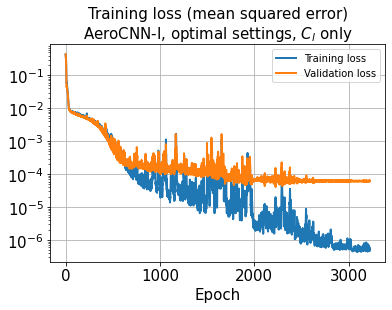

In [41]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

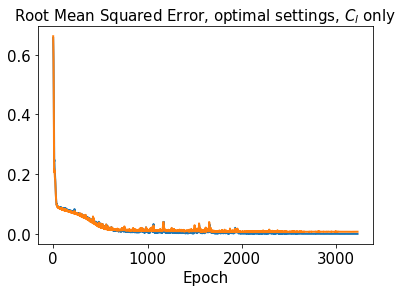

In [42]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

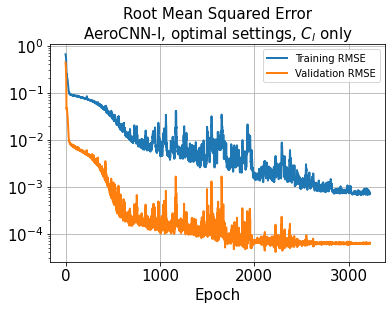

In [43]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [44]:
train_results = model.evaluate([x_train, x_para_train], y_train)

4/4 [==============================] - 0s 15ms/step - loss: 2.2584e-05 - rmse: 0.0048


In [45]:
test_results = model.evaluate([x_test, x_para_test], y_test)

1/1 [==============================] - 0s 56ms/step - loss: 3.8560e-05 - rmse: 0.0062


In [46]:
decoded_train_ = model.predict([x_train, x_para_train])
decoded_val_ = model.predict([x_val, x_para_val])
decoded_test_ = model.predict([x_test, x_para_test])

1/1 [==============================] - 0s 16ms/step


In [47]:
index_train = np.unique(np.where(np.isin(cl, y_train)))
index_val = np.unique(np.where(np.isin(cl, y_val)))
index_test = np.unique(np.where(np.isin(cl, y_test)))

In [48]:
y_train = y_train*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
y_val = y_val*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
y_test = y_test*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)

In [49]:
decoded_train = decoded_train_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
decoded_val = decoded_val_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
decoded_test = decoded_test_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)

In [50]:
model_directory = "D:\\TrainedModels\\20221205"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221205steadyValidation_AeroCNN1_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels) +"kernels_optimalSettings_Clonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = np.abs(decoded_train - y_train)

In [52]:
error_val_abs = np.abs(decoded_val - y_val)

In [53]:
error_test_abs = np.abs(decoded_test - y_test)

In [54]:
os.chdir(storage_dir)

In [55]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.007261779318405373


In [56]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.010093802883172253


In [57]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.009288958101235334


In [58]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [59]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum((y_val[i]+1e-07)**2))
    l2_error_val_list.append(l2_error_val_data)

In [60]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

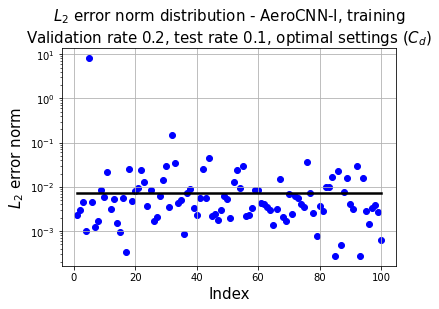

In [61]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

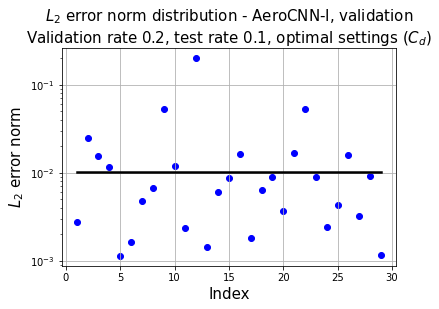

In [62]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, validation\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

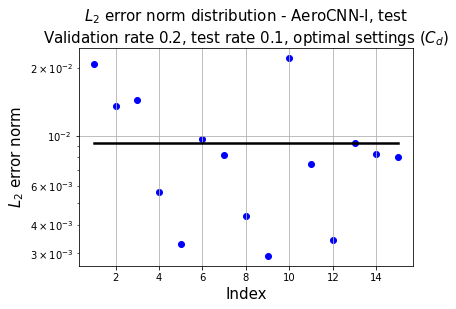

In [63]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict([x, x_para])

5/5 [==============================] - 0s 12ms/step


In [65]:
def CL_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest):
    
    #title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl
    
    #title_n_Cd = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_D$ prediction, L2 error=%.4f'%(l2_error_Cd)
    title_n_Cl = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_L$ prediction, L2 error=%.4f'%(l2_error_Cl)
    
    if i==0:
#         title_Cd, title_Cl = title_0_Cd, title_0_Cl
#         savename1,savename2 = "CdComparison_NACA0018.jpg", "ClComparison_NACA0018.jpg"
        title_Cl = title_0_Cl
        savename2 = "ClComparison_NACA0018.jpg"
    else:
#         title_Cd, title_Cl = title_n_Cd, title_n_Cl
        title_Cl = title_n_Cl
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    '''# CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cd, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='b', label='Training set')
    plt.scatter(aVal, iVal*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='g', label='Validation set')
    plt.scatter(aTest, iTest*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()'''

   # CL graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aVal, iVal, color='g', label='Validation set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 2])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

1/1 [==============================] - 0s 55ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cl: 0.0121


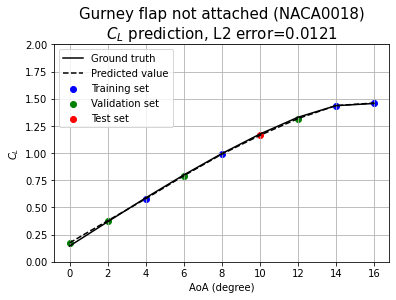

1/1 [==============================] - 0s 17ms/step
L2 error of Cl: 0.0064


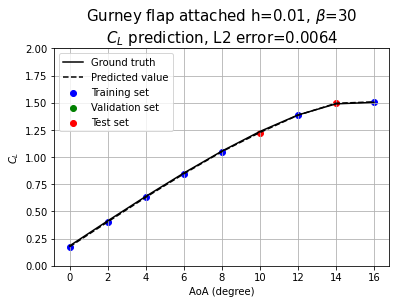

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0056


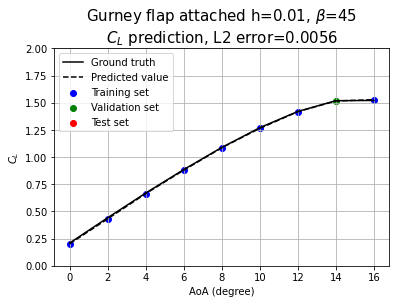

1/1 [==============================] - 0s 18ms/step
L2 error of Cl: 0.0058


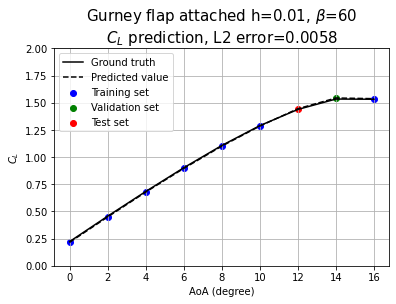

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0053


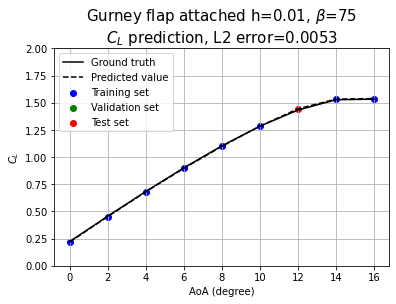

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0036


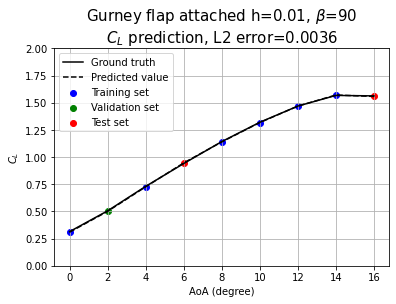

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0077


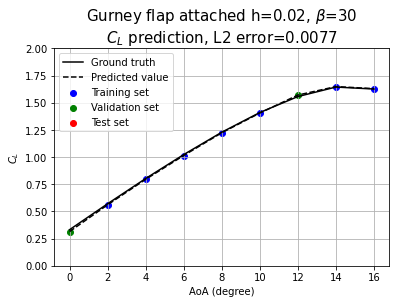

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0065


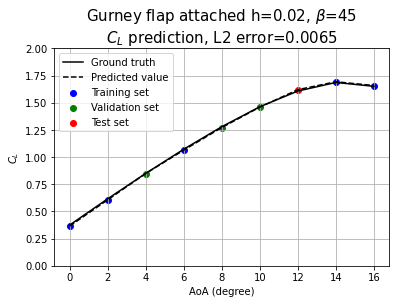

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0043


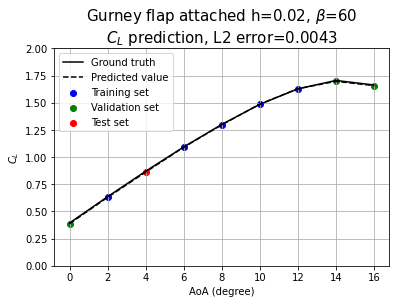

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0074


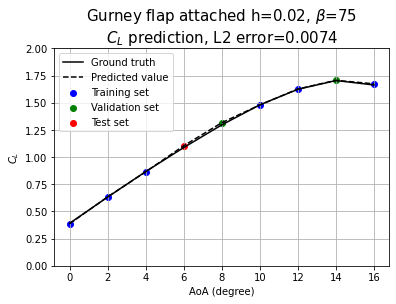

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0111


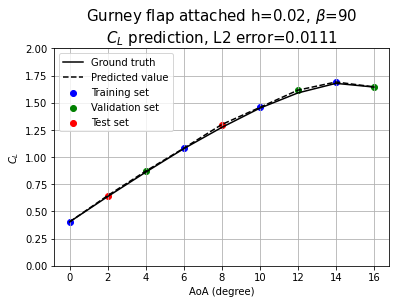

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0043


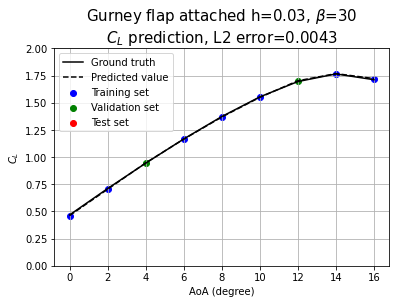

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0057


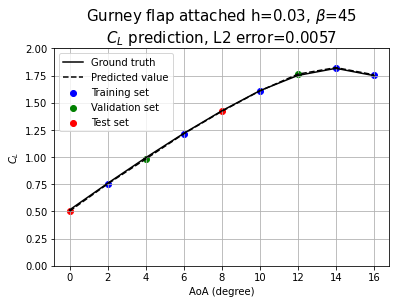

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0044


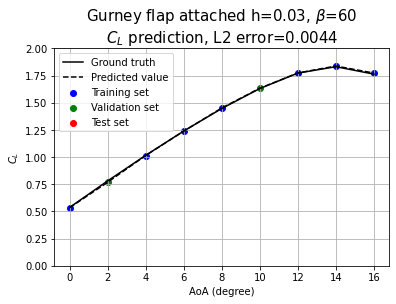

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0043


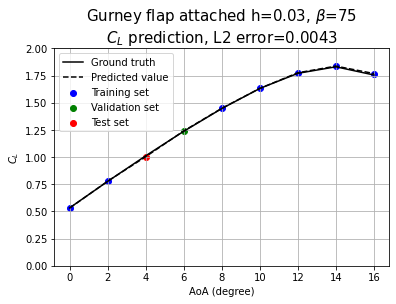

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0327


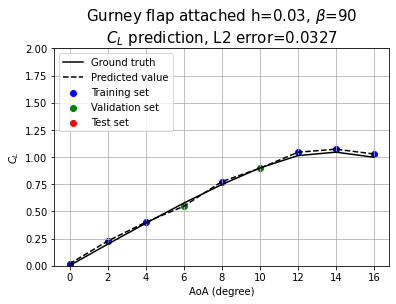

In [66]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    predictedValue = model.predict([x[n_alpha*i:n_alpha*(i+1),:], x_para[n_alpha*i:n_alpha*(i+1),:]])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cl = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    else:
        print('L2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1)]*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    CL = y[n_alpha*i:n_alpha*(i+1)]*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal.append(predicted[index])    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    iTest = np.array(iTest)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    iVal = np.array(iVal)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)*np.max(alpha)
    aVal = np.array(alpha_val)*np.max(alpha)
    aTest = np.array(alpha_test)*np.max(alpha)
    
    CL_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest)